# ZEISS Interview Take-home-task

In [1]:
# Python environment:
# python      v. 3.10.10
# jupyter lab v. 4.1.5
# pandas      v. 2.2.1
# numpy       v. 1.26.4
# matplotlib  v. 3.8.2
# seaborn     v. 0.13.2

import pandas as pd
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(12, 8)})

# 0. Import data and initial observations
Since the problem setup does not provide in-depth explanation of this data, some initial exploration is required

In [2]:
# First, we load the dataframe and make sure the datetime has the correct dtype
temps = pd.read_csv('data//sample_temperature_data_for_coding_challenge.csv',
                    parse_dates=['datetime'])

# inspect the contents of the dataframe
temps.head(3)

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13 17:51:16+00:00,heating_temperature,33.3
1,MICDEV001,2019-04-13 17:51:16+00:00,cooling_temperature,15.0
2,MICDEV001,2019-04-13 18:51:18+00:00,heating_temperature,34.0


In [3]:
# To quickly check the type of data and information contained in the column, we count unique elements in each column
for c in temps.columns:
    print(f'Column "{c}":\t {temps[c].nunique()} unique value(s),\t {temps[c].isnull().sum()} missing value(s),',end='\t')
    # in case there aren't many distinct entries in the column, we can print them out along with their value counts
    if temps[c].nunique()<5:
        print(temps[c].value_counts(dropna=False).to_dict())
    else:
        print()

# The outcome indicates that source_id is always constant, and property_name indicates either a heating or cooling temperature. There are no missing values.

Column "source_id":	 1 unique value(s),	 0 missing value(s),	{'MICDEV001': 1000}
Column "datetime":	 716 unique value(s),	 0 missing value(s),	
Column "property_name":	 2 unique value(s),	 0 missing value(s),	{'heating_temperature': 699, 'cooling_temperature': 301}
Column "temperature":	 172 unique value(s),	 0 missing value(s),	


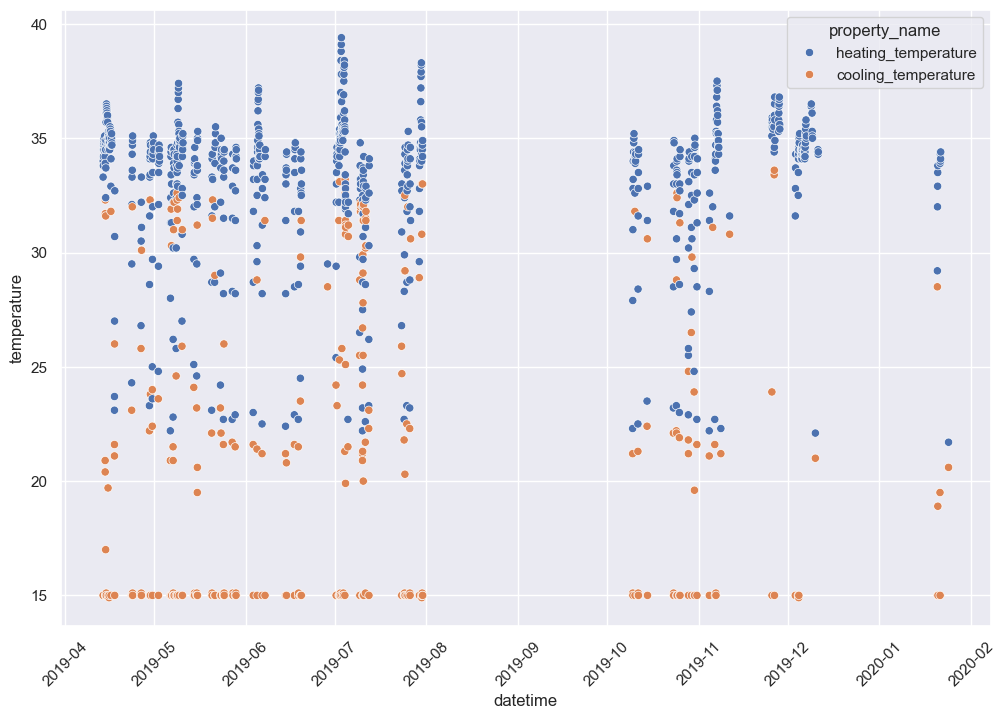

In [4]:
# To better visualize the data, let's plot the temperature values over the datetime, separating the cooling and heating temperatures by color
ax = sns.scatterplot(data=temps, x="datetime", y="temperature",hue="property_name")
ax.tick_params(axis='x', labelrotation=45)

### Initial observations:
- The dataset consists of 1000 temperature measurements, spread over the period of roughly one year (Apr. 2019 - Feb. 2020), with clearly visible gaps in the range of days or even months
- There are no NULL values, and the temperature readings are all in range of [14.9,39.4] degrees
- The "cooling_temperature" readings clearly divided in two groups - one with temperatures around 15 degrees, and another mostly in the range of [19,34] degrees
- It is not yet clear if this is an indication of an error or some limitation of the data collection

### Next steps:
- Collect more information about clustering of cooling_temperature data
- Investigate possible temporal dependencies in the data
- Look for ways to detect abnormal behavior in the data

# 1. Closer data inspection

<Axes: xlabel='temperature', ylabel='Count'>

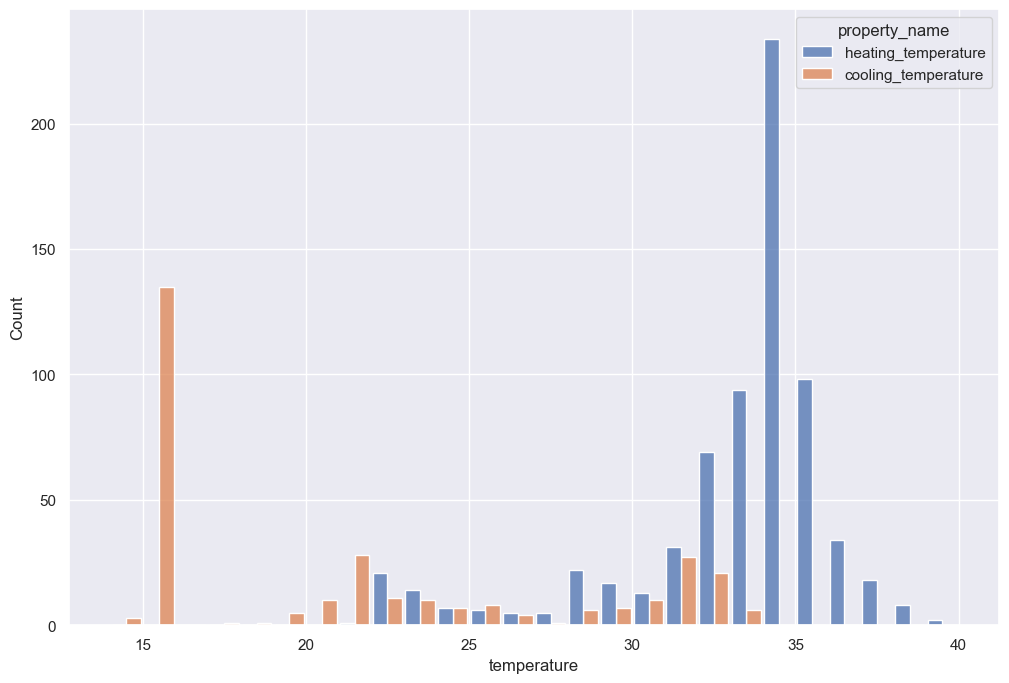

In [5]:
# Looking at the distribution of temperature readings overall, it seems that both cooling and heating temperatures follow a multi-modal distribution
# The value of 15 degrees is most probably used as some "default" value for the cooling temperature
sns.histplot(data=temps, x="temperature", hue="property_name", bins=list(range(14,41)), multiple="dodge", shrink=0.9)

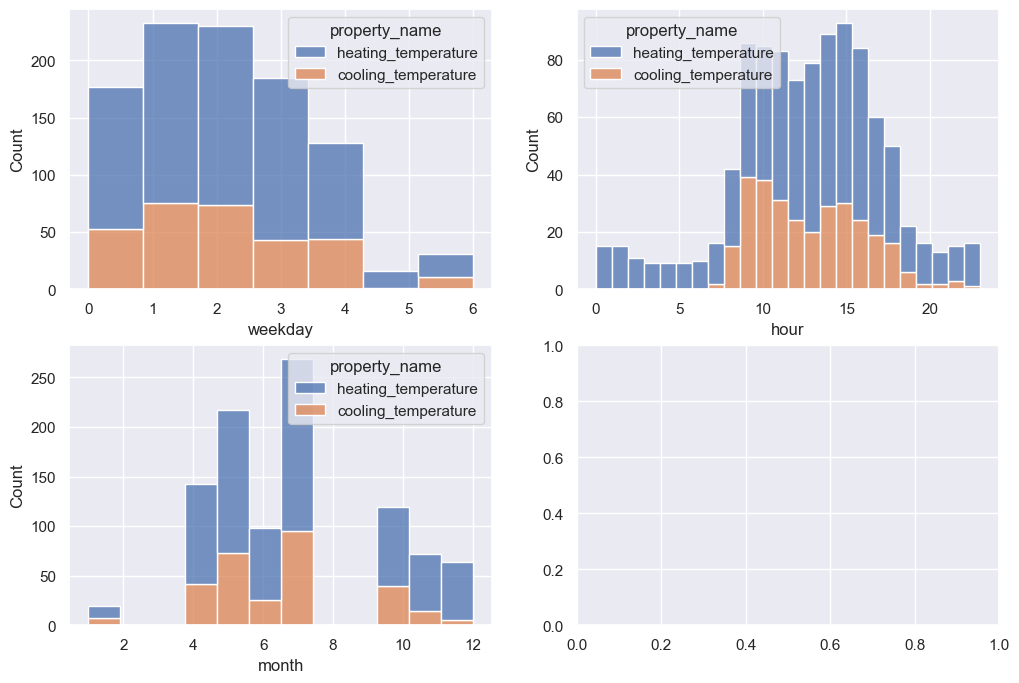

In [6]:
# With temporal data we can expect some oscillating patterns, that could be observed at different frequencies.
# To look at it more closely, we will introduce a few derivative features from the timestamps

temps['weekday'] = temps['datetime'].dt.weekday   # Monday = 0  ... Sunday = 6
temps['month'] = temps['datetime'].dt.month       # January = 1 ... December = 12
temps['hour'] = temps['datetime'].dt.hour         # 0 .. 23

fig, axes = plt.subplots(2,2)
# because some months don't have any data, we need to hard-code the bin counts for the histogram, otherwise we could set
# bins = temps[c].nunique()
for i,(c,bins) in enumerate(zip(['weekday','month','hour'],[7,12,24])):
    sns.histplot(data=temps, x=c, hue="property_name",multiple="stack", bins=bins, ax=axes[i%2,i//2])

### Observations:
- temporal data has distinct "worktime" pattern - more data is present for the wordays and working hours
- cooling temperature almost exclusively collected during "worktime"
- monthly data shows less regular behavior, but we can notice more cooling data present in summer months (esp. May, July), which can indicate correlation with the temperature of the environment

In [7]:
# some timestamps appear multiple times in the dataset, and it would be interesting to see what kind of data is collected for the same dataset
timestamps = temps.groupby('datetime')['source_id'].count().rename('count')

# we can add this count as another feature to the initial dataset to determine possible correlations
temps2 = temps.join(timestamps, on='datetime')

In [8]:
# From these observations we can conclude that
# - cooling_temperature reading almost always comes together with the heating_temperature reading
# - heating_temperature reading can appear on its own
# - but cooling_temperature reading extremely rarely appears on its own
# This could be either a sign of an anomaly, or simply a processing delay
temps2.groupby(['count','property_name'])[['source_id']].count()

source_id
count property_name                 
1     cooling_temperature         17
      heating_temperature        415
2     cooling_temperature        284
      heating_temperature        284

In [9]:
# Let us look closer at the frequency of data timestamps. First, we will check the whole dataset to determine the time delay between consecutive measurements
timestamps.sort_index(inplace=True)
tdeltas = (timestamps.index[1:]-timestamps.index[0:-1]).to_series(name='overall time deltas')
tdeltas.describe()

count                          715
mean     0 days 09:35:15.132867132
std      3 days 04:56:39.136836443
min                0 days 00:03:47
25%                0 days 01:00:01
50%                0 days 01:00:02
75%                0 days 01:00:02
max               70 days 22:50:27
Name: overall time deltas, dtype: object

In [10]:
# Now, since we only have 17 "suspicious" single cooling_temperature readings, we can just iterate over them and determine the closest time stamp
single_cooling_meas = temps2.query('property_name=="cooling_temperature" and count==1').copy()
single_cooling_meas.sort_values('temperature',inplace=True)

# Of course, we need to remove these timestamps from the overall list first (given that there are only 716 of them, such a brute-force approach is acceptable)
other_timestamps = np.array(list(set(timestamps.index).difference(single_cooling_meas['datetime'])))
for _,row in single_cooling_meas.iterrows():
    print(row['temperature'],'\t',min(abs(row['datetime']-other_timestamps)))

14.9 	 0 days 01:00:01
15.0 	 0 days 01:00:01
15.0 	 0 days 01:00:02
15.0 	 0 days 01:00:02
15.0 	 0 days 02:00:03
15.1 	 0 days 01:00:01
15.1 	 0 days 01:00:02
19.5 	 0 days 01:00:01
22.1 	 0 days 00:55:44
25.3 	 0 days 00:48:02
29.0 	 0 days 00:36:34
30.3 	 0 days 00:19:21
30.8 	 0 days 00:07:33
31.1 	 0 days 00:24:11
31.7 	 0 days 00:18:47
32.4 	 0 days 00:12:34
32.5 	 0 days 00:42:24


### Observations:
- Overall, the vast majority of the datapoints are collected hourly, less than 10% of points are collected at a higher frequency
- Disproving my initial hypothesis, there are no cases of processing delay, shortest period between consequtive measurements is over 200s
- 8 of the 17 single cooling_temperature measurements appear at the correct frequency, so it is the heating temperature measurement that's missing in these cases
- There is a very clear correlation between the temperature reading and the "regularity" of the timestamp - my hypothesis is that above ~20 degrees there might be a triggering condition that prompts a new value for the cooling

# 2. Distributions of values
So far we primarily looked at frequencies of values separately from the values themselves.
As the next step in investigating the underlying structure we can consider the distributions of temperature readings themselves - though we have seen the overall histograms, it could be useful to find more granular visual representations

<Axes: xlabel='hour', ylabel='temperature'>

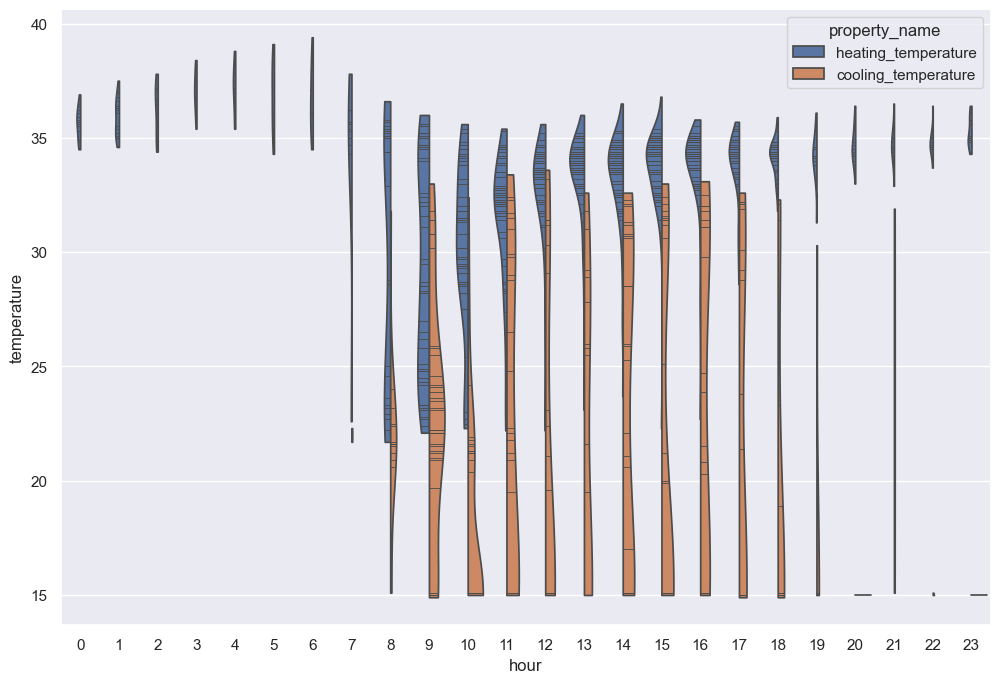

In [11]:
# A useful tool for visualizations of this kind are "violin plots" that extend the standard candlestick plots with more detailed density representation of data

# First, let us consider the hourly distribution of the temperature readings within the dataset
sns.violinplot(data=temps, x="hour", y="temperature", hue="property_name", split=True, inner="stick", cut=0, density_norm="count")

<Axes: xlabel='weekday', ylabel='temperature'>

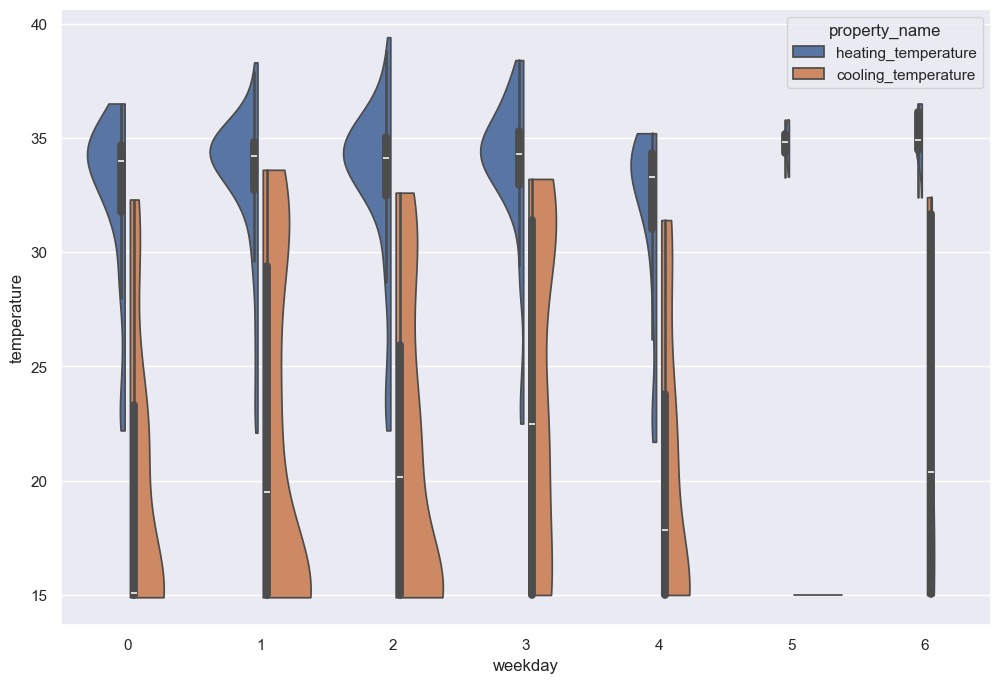

In [12]:
# Similarly, we can plot the information depending on the weekday
sns.violinplot(data=temps, x="weekday", y="temperature", hue="property_name", split=True, gap=.1, inner="box", cut=0, density_norm="count")

<Axes: xlabel='month', ylabel='temperature'>

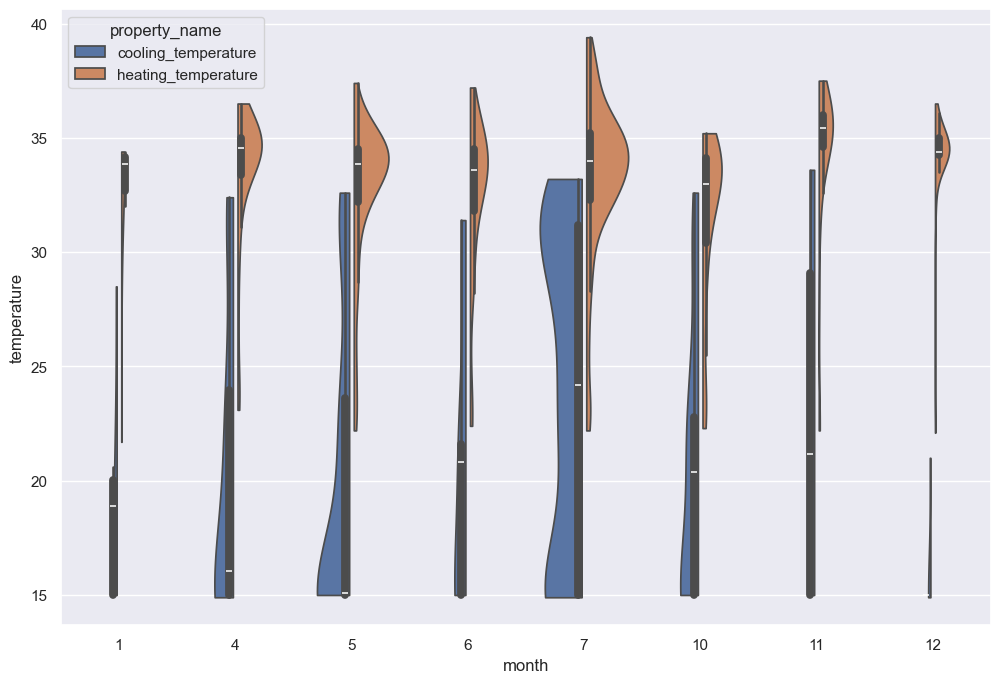

In [13]:
# Lastly, looking at the monthly data we can evaluate potential relation to the temperature of the environment
sns.violinplot(data=temps, x="month", y="temperature", hue="property_name", split=True, gap=.1, inner="box", cut=0, density_norm="count")

### Observations:
- These visualizations confirm previous observations: There is a large discrepancy between the data collected during working hours on workdays, and the data collected outside of these time frames
- Monthly data mainly shows the difference in the volume of data, but there doesn't seem to be a big yearly trend. The low volume of cooling data for the winter months could be explained by lower environment temperature, yet could also be just correlated with overall reduced volume of measurements
- The biggest trends can be observed in the hourly data - beyond the separation between working hours and the rest, one can spot different phases appearing throught the workday - the second mode in the heating_temperature only seem present in the morning hours and could be related to some warm-up phases of the underlying process. It could also be the potential "anomaly", that either stems from the overheating in the preceding hours or absence of some sensor readings before the workday start.